In [1]:
from argparse import ArgumentParser

import torch
import wandb
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from preprocessing.data_pipeline import build_data_pipeline
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from preprocessing.preprocess_ucr import UCRDatasetImporter
from experiments.exp_maskgit import ExpMaskGIT
from evaluation.model_eval import Evaluation
import matplotlib.pyplot as plt


from models.stage2.maskgit import MaskGIT
import os
from pathlib import Path
import tempfile

# from evaluation.evaluation import Evaluation
from utils import (
    get_root_dir,
    load_yaml_param_settings,
    save_model,
    model_filename,
)

dataset = "FordA" 
config_dir = get_root_dir().joinpath("configs", "config.yaml")
config = load_yaml_param_settings(config_dir)
config["dataset"]["dataset_name"] = dataset

dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]

train_data_loader_no_aug = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="train"
)

test_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="test"
)

input_length = train_data_loader_no_aug.dataset.X.shape[-1]

n_classes = len(np.unique(train_data_loader_no_aug.dataset.Y))

maskgit = MaskGIT(
    input_length,
    **config["MaskGIT"],
    config=config,
    n_classes=n_classes,
)

# load
fname = f"maskgit-{dataset}.ckpt"
try:
    ckpt_fname = os.path.join("saved_models", fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
except FileNotFoundError:
    ckpt_fname = Path(tempfile.gettempdir()).joinpath(fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
    
print("maskgit loaded")

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


self.X_train.shape: (3601, 500)
self.X_test.shape: (1320, 500)
# unique labels (train): [0 1]
# unique labels (test): [0 1]
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
encoder-FordA.ckpt
 encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
decoder-FordA.ckpt
 decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vqmodel-FordA.ckpt
 vqmodel loaded
maskgit loaded


In [2]:
probs, s_array, entropy, sel_entropy = maskgit.iterative_decoding(stats=True)

AttributeError: module 'torch' has no attribute 'isfinit'

In [3]:
# Visualize probability distributions using histograms
def plot_probability_histograms(aggregated_probs):
    num_tokens = aggregated_probs.shape[1]
    
    fig, axs = plt.subplots(num_tokens, figsize=(10, num_tokens * 3))
    for i in range(num_tokens):
        # Filter out infinite and NaN values
        probs = aggregated_probs[:, i].flatten().cpu().numpy()
        finite_probs = probs[np.isfinite(probs) & ~np.isnan(probs)]

        axs[i].hist(finite_probs, bins=100, alpha=0.5)
        axs[i].set_title(f"t =  {i+1}: Conditional distribution")
        axs[i].set_xlabel("Probability")
        axs[i].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def plot_entropy_histograms(aggregated_entropy):
    num_tokens = aggregated_entropy.shape[1]
    
    fig, axs = plt.subplots(num_tokens, figsize=(10, num_tokens * 3))
    for i in range(num_tokens):
        # Filter out infinite and NaN values
        entropy_vals = aggregated_entropy[:, i].flatten().cpu().numpy()
        finite_entropy = entropy_vals[np.isfinite(entropy_vals)]
        
        axs[i].hist(finite_entropy, bins=20, alpha=0.5)
        axs[i].set_title(f"t = {i+1}: Entropy Distribution")
        axs[i].set_xlabel("Entropy")
        axs[i].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()


# Visualize mean probability as a function of iteration number t
def plot_mean_probability_vs_iteration(mean_probs):
    num_tokens = mean_probs.shape[1]
    num_iterations = mean_probs.shape[0]
    
    plt.figure(figsize=(10, 6))
    for i in range(num_tokens):
        plt.plot(np.arange(1, num_iterations + 1), mean_probs[:, i], label=f"Token {i+1}")
    plt.xlabel("Iteration Number (t)")
    plt.ylabel("Mean Probability")
    plt.title("Mean Probability vs. Iteration Number")
    plt.legend()
    plt.grid(True)
    plt.show()


# Visualize mean probability as a function of iteration number t
def plot_mean_probability_std_vs_iteration(mean_probs):
    num_tokens = mean_probs.shape[1]
    num_iterations = mean_probs.shape[0]
    
    plt.figure(figsize=(10, 6))
    for i in range(num_tokens):
        mean = mean_probs[:, i].squeeze_()
        finite_mean = mean[torch.isfinite(mean)]  # Filter out infinite values
        print(finite_mean)
        std = torch.std(finite_mean, unbiased=False) if len(finite_mean) > 1 else 0  # Calculate standard deviation for finite values, handle case where only one value exists

        #print(finite_mean.detach())
        #print(np.std(finite_mean))
        #std = np.std(finite_mean, axis=0, ddof=1) if len(finite_mean) > 1 else 0  # Calculate standard deviation for finite values, handle case where only one value exists
        
        print(mean.shape)
        print(std)
        #plt.errorbar(np.arange(1, num_iterations + 1), mean, yerr=std, label=f"Token {i+1}")

    plt.xlabel("Iteration Number (t)")
    plt.ylabel("Mean Probability")
    plt.title("Mean Probability with Standard Deviation vs. Iteration Number")
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Visualize mean entropy as a function of iteration number t
def plot_mean_entropy_vs_iteration(mean_entropy):
    num_tokens = mean_entropy.shape[1]
    num_iterations = mean_entropy.shape[0]
    
    plt.figure(figsize=(10, 6))
    for i in range(num_tokens):
        plt.plot(np.arange(1, num_iterations + 1), mean_entropy[:, i], label=f"Token {i+1}")
    plt.xlabel("Iteration Number (t)")
    plt.ylabel("Mean Entropy")
    plt.title("Mean Entropy vs. Iteration Number")
    plt.legend()
    plt.grid(True)
    plt.show()



In [4]:
from tqdm import tqdm

# Visualize mean probability as a function of iteration number t
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def aggregate_iterative_decoding(maskgit, num_iterations=10, finite=True):
    results = []

    for _ in tqdm(range(num_iterations)):
        _, probs_array, entropy_array, sel_entropy_array = maskgit.iterative_decoding(stats=True)
        results.append((probs_array, entropy_array, sel_entropy_array))

    # Aggregate results across iterations-
    aggregated_probs = torch.stack([torch.stack(probs) for probs, _, _ in results])
    aggregated_entropy = torch.stack([torch.stack(entropy) for _, entropy, _ in results])
    aggregated_sel_entropy = torch.stack([torch.stack(sel_entropy) for _, _, sel_entropy in results])

    #broadcasting: (num_iterations, t, 1, num tokens) -> (num_iterations, t, num_tokens)
    aggregated_probs = torch.squeeze(aggregated_probs, dim=2) 
    aggregated_entropy = torch.squeeze(aggregated_entropy, dim=2)
    aggregated_sel_entropy = torch.squeeze(aggregated_sel_entropy, dim=2)
    
    return aggregated_probs, aggregated_entropy, aggregated_sel_entropy

# Example usage
agg_probs, agg_entropy = aggregate_iterative_decoding(maskgit, num_iterations=100)

agg_probs.shape, agg_entropy.shape


  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: module 'torch' has no attribute 'isfinit'

In [7]:
#print("Aggregated probability distributions", agg_probs)
p = agg_probs[0][4]
p_with_inf = p

#drop inf values
p_without_inf = p[torch.isfinite(p)]

#calculate entropy of p with inf and without
entropy_with_inf = -torch.sum(p_with_inf * torch.log(p_with_inf))
entropy_without_inf = -torch.sum(p_without_inf * torch.log(p_without_inf))

#print("Entropy with inf", entropy_with_inf)
#print("Entropy without inf", entropy_without_inf)

# Visualize probability distributions using histograms
#plot_probability_histograms(agg_probs)

Text(0, 0.5, 'Mean and Std of agg_probs')

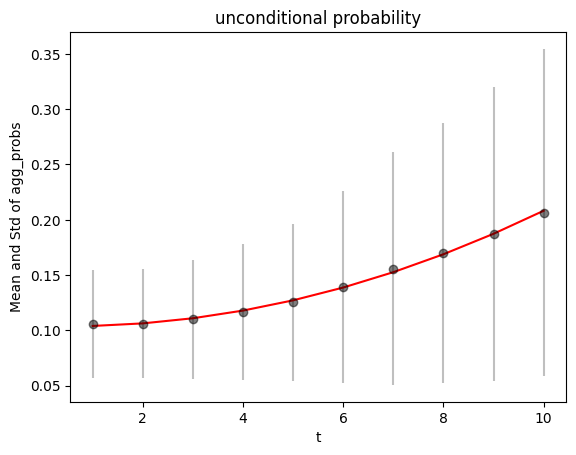

In [11]:
a,b,c = agg_probs.shape
flat_agg_probs = agg_probs.permute(1, 0, 2).reshape(b, a * c)
# extract finite vales on 1 dim

import matplotlib.pyplot as plt
import numpy as np

# Calculate the means and standard deviations along the second axis
means = []
stds = []

for i in range(flat_agg_probs.shape[0]):
    probs = flat_agg_probs[i]

    means.append(torch.mean(probs[torch.isfinite(probs)]))
    stds.append(torch.std(probs[torch.isfinite(probs)]))

# Create an array for the "t" values
t_values = np.arange(1, len(means) + 1)

# Fit a line to the mean values
fit = np.polyfit(t_values, means, 2)
fit_fn = np.poly1d(fit)

# Plot the means and standard deviations
plt.errorbar(t_values, means, yerr=stds, fmt='ok', ecolor='gray', alpha=0.5)

# Plot the fit line
plt.plot(t_values, fit_fn(t_values), 'r-')

plt.title('unconditional probability')
plt.xlabel('t')
plt.ylabel('Mean and Std of agg_probs')

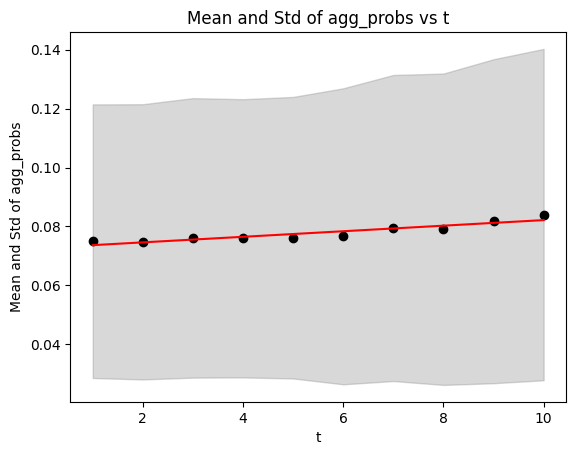

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the means and standard deviations along the second axis
means = []
stds = []

for i in range(flat_agg_probs.shape[0]):
    probs = flat_agg_probs[i]

    means.append(torch.mean(probs[torch.isfinite(probs)]))
    stds.append(torch.std(probs[torch.isfinite(probs)]))

# Create an array for the "t" values
t_values = np.arange(1, len(means) + 1)

# Fit a line to the mean values
fit = np.polyfit(t_values, means, 1)
fit_fn = np.poly1d(fit)

# Plot the means
plt.plot(t_values, means, 'ok')

# Plot the fit line
plt.plot(t_values, fit_fn(t_values), 'r-')

# Add a shaded area representing the standard deviation
plt.fill_between(t_values, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='gray', alpha=0.3)

plt.title('Mean and Std of agg_probs vs t')
plt.xlabel('t')
plt.ylabel('Mean and Std of agg_probs')
plt.show()

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


Text(0, 0.5, 'entropy')

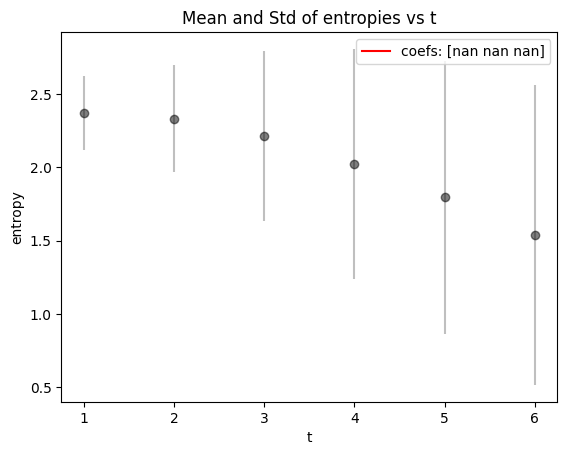

In [9]:
a,b,c = agg_entropy.shape
flat_agg_entropy = agg_entropy.permute(1, 0, 2).reshape(b, a * c)
# extract finite vales on 1 dim

import matplotlib.pyplot as plt
import numpy as np

# Calculate the means and standard deviations along the second axis
means = []
stds = []

for i in range(flat_agg_entropy.shape[0]):
    entropies = flat_agg_entropy[i]

    means.append(torch.mean(entropies))
    stds.append(torch.std(entropies))

# Create an array for the "t" values
t_values = np.arange(1, len(means) + 1)

# Fit a line to the mean values
fit = np.polyfit(t_values, means, 2)
fit_fn = np.poly1d(fit)

# Plot the means and standard deviations
plt.errorbar(t_values, means, yerr=stds, fmt='ok', ecolor='gray', alpha=0.5)


# Plot the fit line
plt.plot(t_values, fit_fn(t_values), 'r-', label=f"coefs: {fit_fn.coefficients}")

#plt.fill_between(t_values, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='gray', alpha=0.3)

plt.legend()
plt.title('Mean and Std of entropies vs t')
plt.xlabel('t')
plt.ylabel('entropy')

In [125]:
import matplotlib.pyplot as plt


print(s.shape, probs[0].shape)

f, a = plt.subplots(10, 1, figsize=(10, 100))

for i in range(len(probs)):
    p = probs[i].squeeze_()
    #m = masks[i].squeeze_()
    a[i].imshow(p.cpu().detach().numpy())
#    a[i][1].imshow(m.cpu().detach().numpy())

plt.tight_layout()
plt.show()
    

NameError: name 's' is not defined